## Импорт библиотек

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import product
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from math import ceil
from datetime import datetime
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)



## Загрузка датасета и отбрасывание outliers

In [2]:
dataset = pd.read_csv('dataset.csv')
dataset.drop(columns='Unnamed: 0', inplace=True, axis=1)
dataset.local_date = pd.to_datetime(dataset.local_date)
dataset.local_date = dataset.local_date.round('H')
dataset['hour'] = dataset.local_date.dt.hour
dataset['day'] = dataset.local_date.dt.day
dataset['revenue'] = dataset.price*dataset.quantity

#удаляем данные не относящиеся к последней неделе
dataset = dataset[dataset.local_date.dt.year >= 2021]
dataset = dataset[dataset.local_date.dt.month >= 2]
dataset = dataset[dataset.local_date.dt.day >= 1]

#удаляем возвраты/отрицательные значения
dataset = dataset[dataset.quantity > 0]
dataset = dataset[dataset.price > 0]

#помечаем колонки как категории
dataset['region'] = dataset['region'].astype('category')
dataset['region_str'] = dataset['region'].astype('category')
dataset['region'] = dataset['region'].cat.codes

#отбрасываем записи без barcode
dataset.dropna(inplace=True)


In [3]:
print(dataset.barcode.isna().sum())

0


## Описание полей в датасете:
item_id            Id транзакции<br> 
receipt_id        Id чека<br> 
device_id        Id кассового аппарата<br> 
local_date       Дата и время покупки<br> 
barcode           Штрихкод<br> 
price                Цена покупки, рубли<br> 
quantity           Количество купленного товара, шт.<br> 
region              Регион

## Статистика по датасету

In [4]:
dataset.describe()

,item_id,receipt_id,device_id,price,quantity,region,hour,day,revenue
count,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06
mean,1.169169e+10,7.382236e+09,3.524287e+14,1.444292e+02,1.851711e+00,4.073841e+01,1.462635e+01,3.580773e+00,1.605691e+02
std,2.543894e+07,1.441252e+07,3.246692e+11,1.142864e+03,1.501325e+01,2.319679e+01,3.787953e+00,1.700235e+00,1.366103e+03
min,1.164705e+10,7.356678e+09,3.523991e+14,1.000000e-02,1.000000e-03,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-02
25%,1.166987e+10,7.369880e+09,3.524015e+14,3.100000e+01,1.000000e+00,2.200000e+01,1.200000e+01,2.000000e+00,3.800000e+01
50%,1.169178e+10,7.382427e+09,3.524038e+14,7.000000e+01,1.000000e+00,3.700000e+01,1.500000e+01,4.000000e+00,8.400000e+01
75%,1.171401e+10,7.394917e+09,3.524060e+14,1.350000e+02,1.000000e+00,6.200000e+01,1.800000e+01,5.000000e+00,1.430000e+02
max,1.173505e+10,7.406571e+09,3.566551e+14,1.000000e+06,4.280000e+03,8.400000e+01,2.300000e+01,7.000000e+00,1.000000e+06


## Уникальные значения

In [5]:
for col in dataset.columns:    
    unique = dataset[col].unique()
    print('Feature: {0} unique: {1}\n'.format(col, len(unique)))
    print(unique,'\n')

Feature: item_id unique: 1015306

[11660931229 11660931230 11660931773 ... 11660931118 11660931119
 11660931120] 

Feature: receipt_id unique: 508250

[7364786357 7364786673 7364786762 ... 7364786210 7364786218 7364786270] 

Feature: device_id unique: 3186

[352402250963288 352403179996511 352403718712896 ... 352405120366626
 352402001420454 352405211401395] 

Feature: local_date unique: 152

['2021-02-02T00:00:00.000000000' '2021-02-02T02:00:00.000000000'
 '2021-02-02T01:00:00.000000000' '2021-02-02T03:00:00.000000000'
 '2021-02-02T05:00:00.000000000' '2021-02-02T07:00:00.000000000'
 '2021-02-01T00:00:00.000000000' '2021-02-01T07:00:00.000000000'
 '2021-02-01T02:00:00.000000000' '2021-02-01T06:00:00.000000000'
 '2021-02-01T03:00:00.000000000' '2021-02-01T01:00:00.000000000'
 '2021-02-01T08:00:00.000000000' '2021-02-06T17:00:00.000000000'
 '2021-02-06T10:00:00.000000000' '2021-02-06T11:00:00.000000000'
 '2021-02-06T14:00:00.000000000' '2021-02-06T15:00:00.000000000'
 '2021-02-06T16:00:

## Выбираем штрихкоды для бутылок Coca-cola

In [6]:
# br=dataset.barcode.value_counts()
# import requests
# from urllib.request import Request, urlopen
# import urllib
# from bs4 import BeautifulSoup

# headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit 537.36 (KHTML, like Gecko) Chrome","Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"}

# def google(q):
#     q = '+'.join(q.split())
#     url = 'https://www.google.com/search?q=' + q + '&ie=utf-8&oe=utf-8'
#     reqest = Request(url,headers=headers)
#     page = urlopen(reqest)
#     soup = BeautifulSoup(page)
#     return soup.text

# for key, value in br[:500].to_dict().items():
#     req = google(key)
#     req = req.split('выполнена в течение нескольких секунд.')[1][:62]
#     if 'Cola' in req:
#         print(key, req, value)

 5449000228970        Напиток газированный Coca-Cola 0,9 л, код 5449000228970 719<br>
 5449000000286        Напиток безалкогольный сильногазированный Coca-Cola п/б 2л 712<br>
 5449000000996        Вода Coca-Cola ж/б 0.33л Coca-Cola 5449000000996: купит 525<br>
 54491472        Напиток безалкогольный сильногазированный Coca-Cola п/б 485<br>
 4600494602481        Напиток Pepsi-Cola б/алк газ 2л пэт, размер 10.35/10.35 465<br>
 4600494602269        Напиток Pepsi-Cola б/алк газ 1л пэт, размер 8.20/8.20/2 403 <br>

## Данные для Напиток безалкогольный сильногазированный Coca-Cola п/б 2л  5449000000286

In [7]:
df = dataset[dataset.barcode.isin([#'4600494602269', 
                                   #'4600494602481' ,
                                   #'5449000000996',
                                   #'5449000228970', 
                                   '5449000000286', 
                                   # '54491472'
            ])].copy()

df['local_date'] = pd.to_datetime(df['local_date'])
df.reset_index(drop=True, inplace=True)



## Гистограммы цены и количества проданных штук

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'quantity'}>]], dtype=object)

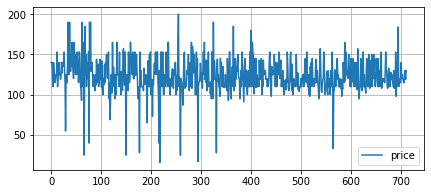

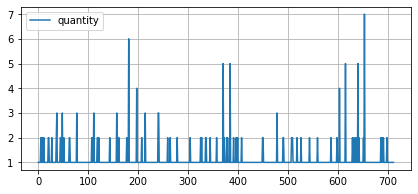

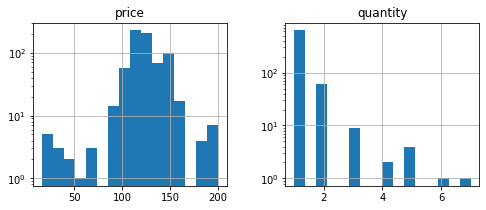

In [8]:
df.plot(y='price', kind='line', figsize=(7,3), grid=True, use_index=True)
df.plot(y='quantity', kind='line', figsize=(7,3), grid=True, use_index=True)
df.hist(column=['price', 'quantity'],bins=16, log=True, figsize=(8,3))

## Функции генерации признаков и временных лагов

In [9]:
def fe(cols_gb, fe_df, matrix, feats, stats, prefix):    
    # agg features
    group = fe_df.groupby(cols_gb)[feats].agg(stats).reset_index()
    if 'local_date' in cols_gb:
        group.local_date = pd.to_datetime(group.local_date)
        matrix.local_date = pd.to_datetime(matrix.local_date)
    # merge
    matrix = matrix.merge(
        group
        , how='left'
        , on=cols_gb
    )
    matrix.fillna(0, inplace=True)    
    matrix.columns = [prefix+"_".join(col).strip() if len(col) == 2 else col for col in matrix.columns.values]    
#     print(matrix.columns.values)
    return matrix

def lag_feature(df, lags, col):
    tmp = df[['region', 'local_date',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['region', 'local_date', col+'_lag_'+str(i)]
        shifted['local_date'] += pd.Timedelta(hours=i)
        df = pd.merge(df, shifted, on=['region', 'local_date'], how='left')
    return df

### Функции скользящего окна для среднего, медианы и экспоненциального взвешивания

In [10]:
# Creating quantity rolling mean features
def create_sales_rmean_feats(df, cols_gb, feats, windows, min_periods=2, 
                             shift=1, win_type=None):
    group = df.groupby(cols_gb)
    for w in windows:
        df['_'.join([feats, 'rmean', str(w)])] = \
            group[feats].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1, size=(len(df),))
    return df

# Creating quantity rolling median features
def create_sales_rmed_feats(df, cols_gb, feats, windows, min_periods=2, 
                            shift=1, win_type=None):
    group = df.groupby(cols_gb)
    for w in windows:
        df['_'.join([feats, 'rmed', str(w)])] = \
            group[feats].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1, size=(len(df),))
    return df

# Creating quantity exponentially weighted mean features
def create_sales_ewm_feats(df, cols_gb, feats, alpha=[0.9], shift=[1]):
    group = df.groupby(cols_gb)
    for a in alpha:
        for s in shift:
            df['_'.join([feats, 'lag', str(s), 'ewm', str(a)])] = \
                group[feats].shift(s).ewm(alpha=a).mean().values
    return df

In [11]:
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

def mae(ytrue, ypred):
    return mean_absolute_error(ytrue, ypred)

### Формируем датасет, включающий нулевые продажи для каждого региона

In [12]:
def make_feature(dataset, regions, day, mode):
    
    matrix = []
    cols = ['region','local_date']
     
    dates = np.array(pd.date_range(dataset.local_date.min(), dataset.local_date.max() + pd.Timedelta(days=1), freq="1h").to_pydatetime()).astype('datetime64[ns]')
    matrix = list(product(regions, dates))    
    matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
    matrix.local_date = pd.to_datetime(matrix.local_date)
    matrix['year'] = matrix.local_date.dt.year
    matrix['month'] = matrix.local_date.dt.month
    matrix['day'] = matrix.local_date.dt.day
    matrix['hour'] = matrix.local_date.dt.hour

    cols_gb = ['region', 'local_date']
    feats = ['quantity']
    stats = ['sum']
    prefix=''
    matrix = fe(cols_gb, dataset, matrix, feats, stats, prefix)
    
#     masked_train = (matrix.day < day) 
#     masked_valid = (matrix.day == day) 
#     masked_test = (matrix.day > day)
    
    masked_train = matrix.local_date < day
    masked_valid = matrix.local_date.between(day, day+pd.Timedelta(days=1, hours=1), inclusive=True)
    masked_test = matrix.local_date > day + pd.Timedelta(days=1)
     
    matrix.loc[(masked_train), 'train_or_test'] = 'train'
    matrix.loc[(masked_valid), 'train_or_test'] = 'val'
    matrix.loc[(masked_test), 'train_or_test'] = 'test'
        
#     print('Train shape: {}'.format(matrix.loc[matrix.train_or_test=='train',:].shape))
#     print('Validation shape: {}'.format(matrix.loc[matrix.train_or_test=='val',:].shape))  
#     print('No train shape: {}'.format(matrix.loc[matrix.train_or_test=='test',:].shape))  
        
    train = matrix.loc[matrix.train_or_test.isin(['train','val']), :].copy()
    Y_train = train.loc[train.train_or_test=='train', 'quantity_sum'].reset_index(drop=True)
    Y_valid = train.loc[train.train_or_test=='val', 'quantity_sum'].reset_index(drop=True)
    train.loc[train.train_or_test=='val', ['quantity_sum']] = np.nan
    train.loc[train.train_or_test=='test', ['quantity_sum']] = np.nan
    
    lags = [24,36,48]
    train = lag_feature(train, lags, 'quantity_sum')
    cols_to_drop = []
    
    #Добавляем "скользящие" признаки
    train = create_sales_rmean_feats(train, cols_gb=['region'], 
                                 feats='quantity_sum', windows=[4,12,24], 
                                 min_periods=4, win_type='triang')

    train = create_sales_rmed_feats(train, cols_gb=['region'], 
                                feats='quantity_sum', windows=[4,12,24], 
                                min_periods=4, win_type=None)

    train = create_sales_ewm_feats(train, cols_gb=['region'], 
                               feats='quantity_sum', 
                               alpha=[0.95, 0.9, 0.85], 
                               shift=[1,4,8])
    
    cols_to_drop += ['year', 'month','local_date','train_or_test','quantity_sum']
    features = [col for col in train.columns.values if col not in cols_to_drop]

    categorical_feats = ['region',
                     'day',
                     'hour']
    for col in categorical_feats:
        train[col] = train[col].astype('category')
        
    X_train = train.loc[train.train_or_test=='train', features].reset_index(drop=True)
    X_valid = train.loc[train.train_or_test=='val', features].reset_index(drop=True)
    
    return X_train, Y_train, X_valid, Y_valid, matrix
    
    


## LigthGBM

In [13]:
import lightgbm as lgb
ts = time.time()

#два режима работы - обучение по 5 дням, 6 на валидацию
#либо обучение на всем датасете для формирования предсказания на 7 день
def lgb_validation(params, lgbtrain, lgbval, X_val, Y_val, verbose_eval, mode):
    model = lgb.LGBMRegressor(**hyper_params)

    if mode == 'train':
        model.fit(
            X_train, 
            Y_train, 
            eval_metric="mae", 
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
            verbose=verbose_eval            
            )
    else:
        model.fit(
            X_train, 
            Y_train,             
            verbose=verbose_eval,            
            )


    Y_pred = model.predict(X_val)
    if mode == 'train':
        print('Scores for GBM ' + mode)
        print('R2 ', r2_score(Y_valid,Y_pred))
        print('RMSE ', rmse(Y_valid,Y_pred))
        print('MAE ', mae(Y_valid,Y_pred))
    
    val_df = pd.DataFrame(columns=['Y_valid','Y_pred'])
    val_df['Y_valid'] = Y_val
    val_df['Y_pred'] = Y_pred
    
    return model, val_df.reset_index(drop=True)

## Обучение c валидацией


C:\Users\bognev\anaconda3\envs\tf-gpu-clone\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


X Train shape:(9600, 21), X Val shape:(2000, 21)
Y Train shape:(9600,), Y Val shape:(2000,)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

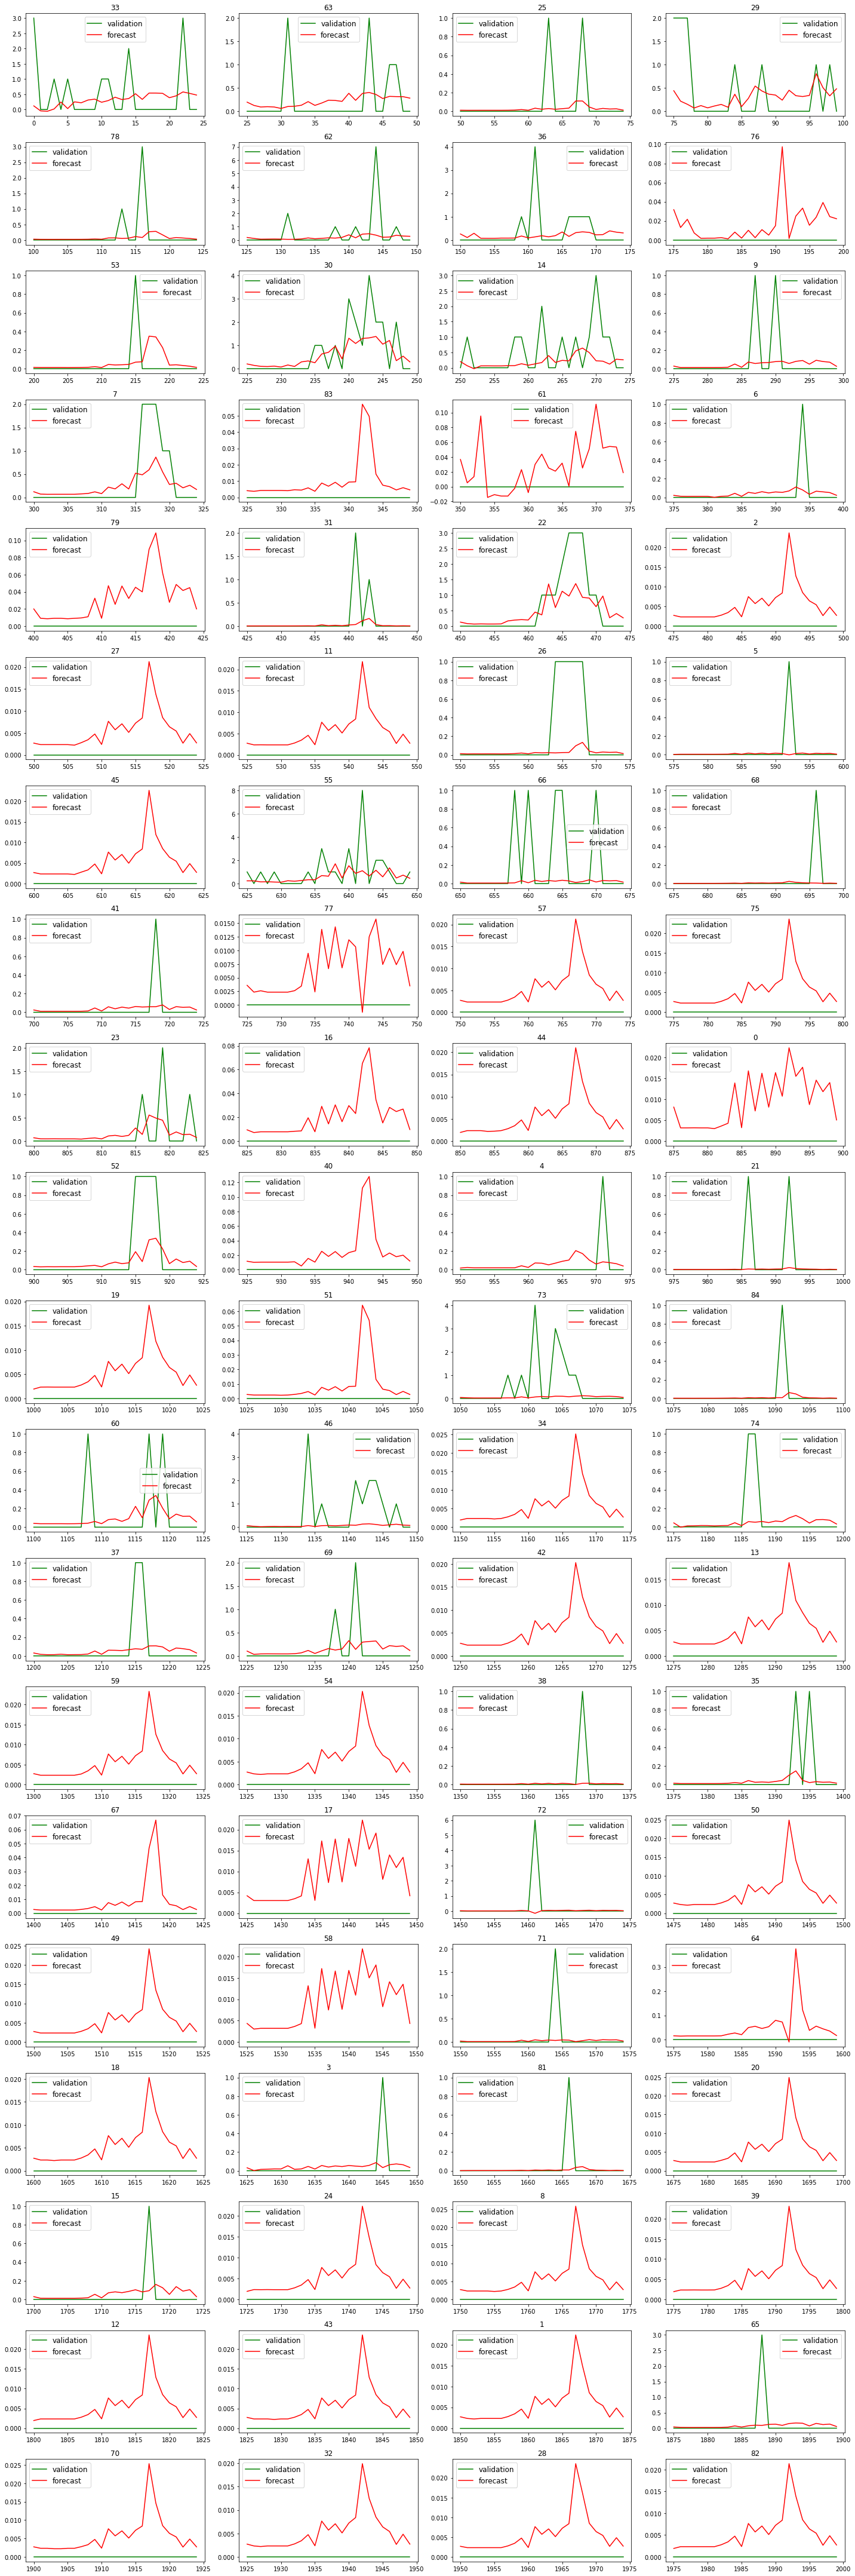

In [14]:
mode = 'train'
valid_day = df.local_date.max()-pd.Timedelta(days=1)
regions = dataset.region.unique()

#Разбиваем на обучающую/валидационную выборки
X_train,Y_train, X_valid, Y_valid, matrix = make_feature(df, regions, valid_day, mode)

# Final train and val datasets
print('X Train shape:{}, X Val shape:{}'.format(X_train.shape, X_valid.shape))
print('Y Train shape:{}, Y Val shape:{}'.format(Y_train.shape, Y_valid.shape))

hyper_params = {'task':'train', 'n_estimators' : 30, 'boosting_type':'gbdt', 'objective':'regression_L2', 
              'metric': 'mae', 'num_leaves': 10, 'learning_rate': 0.01, 
              'feature_fraction': 1, 'max_depth': 5, 'verbose': 0, 
              'num_boost_round':1000, 'early_stopping_rounds':200, 'nthread':-1}

mode = 'train'
model, val_df = lgb_validation(hyper_params, X_train, Y_train, X_valid, Y_valid, 0, mode)
time.time() - ts

X = pd.concat([X_valid, val_df], axis=1)
fig, ax = plt.subplots(20, 4, figsize=(20, 60))
ax = ax.flatten()

for i, reg in enumerate(regions):
    ax[i].plot(X[X.region == reg]['Y_valid'], color='g', label='validation')
    ax[i].plot(X[X.region == reg]['Y_pred'], color='r', label='forecast')
    ax[i].set_title(reg)
    ax[i].legend(prop={"size": 12})
                 
plt.tight_layout()    

## Важность признаков

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

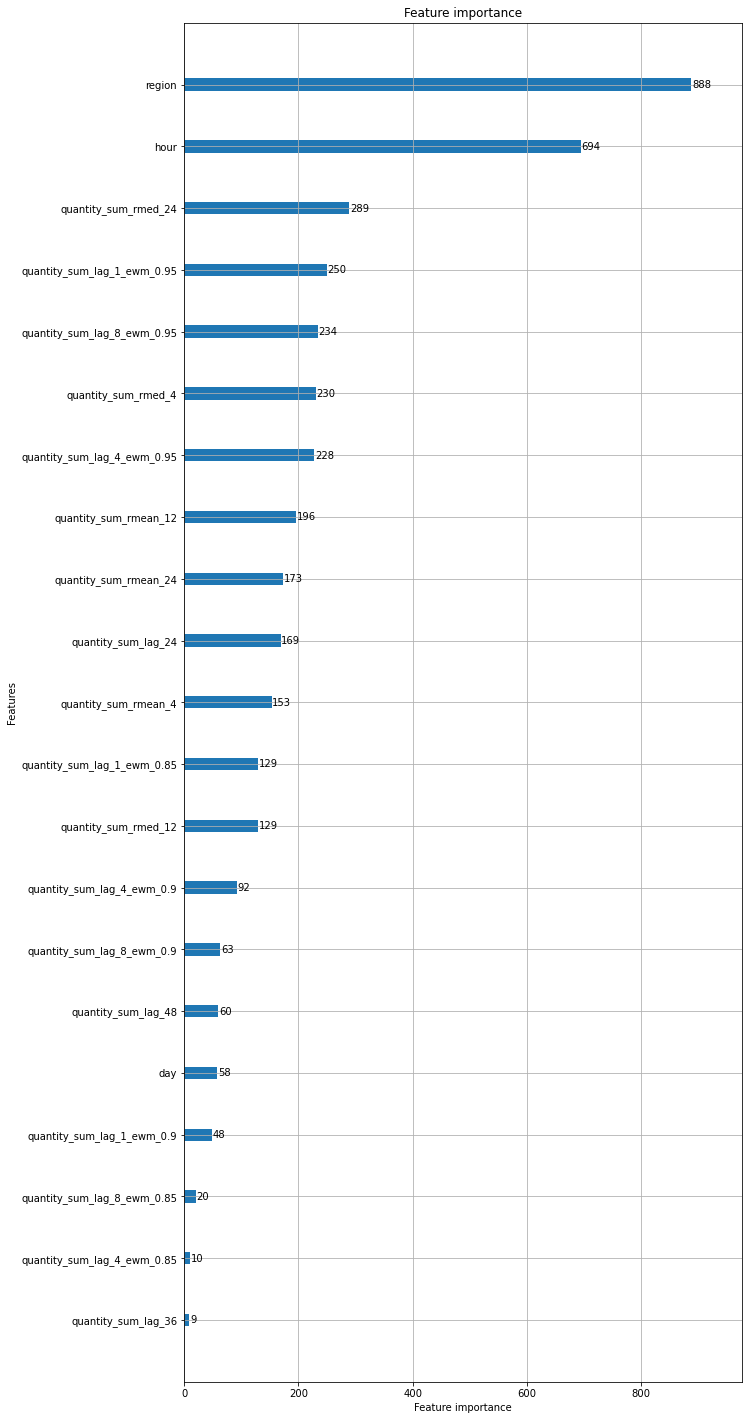

In [15]:
from lightgbm import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,25))

## Базовое решение - значения за предыдщуий день

Scores for Naive validation
R2  -1.3023036032908082
RMSE  0.5567764362830022
MAE  0.147


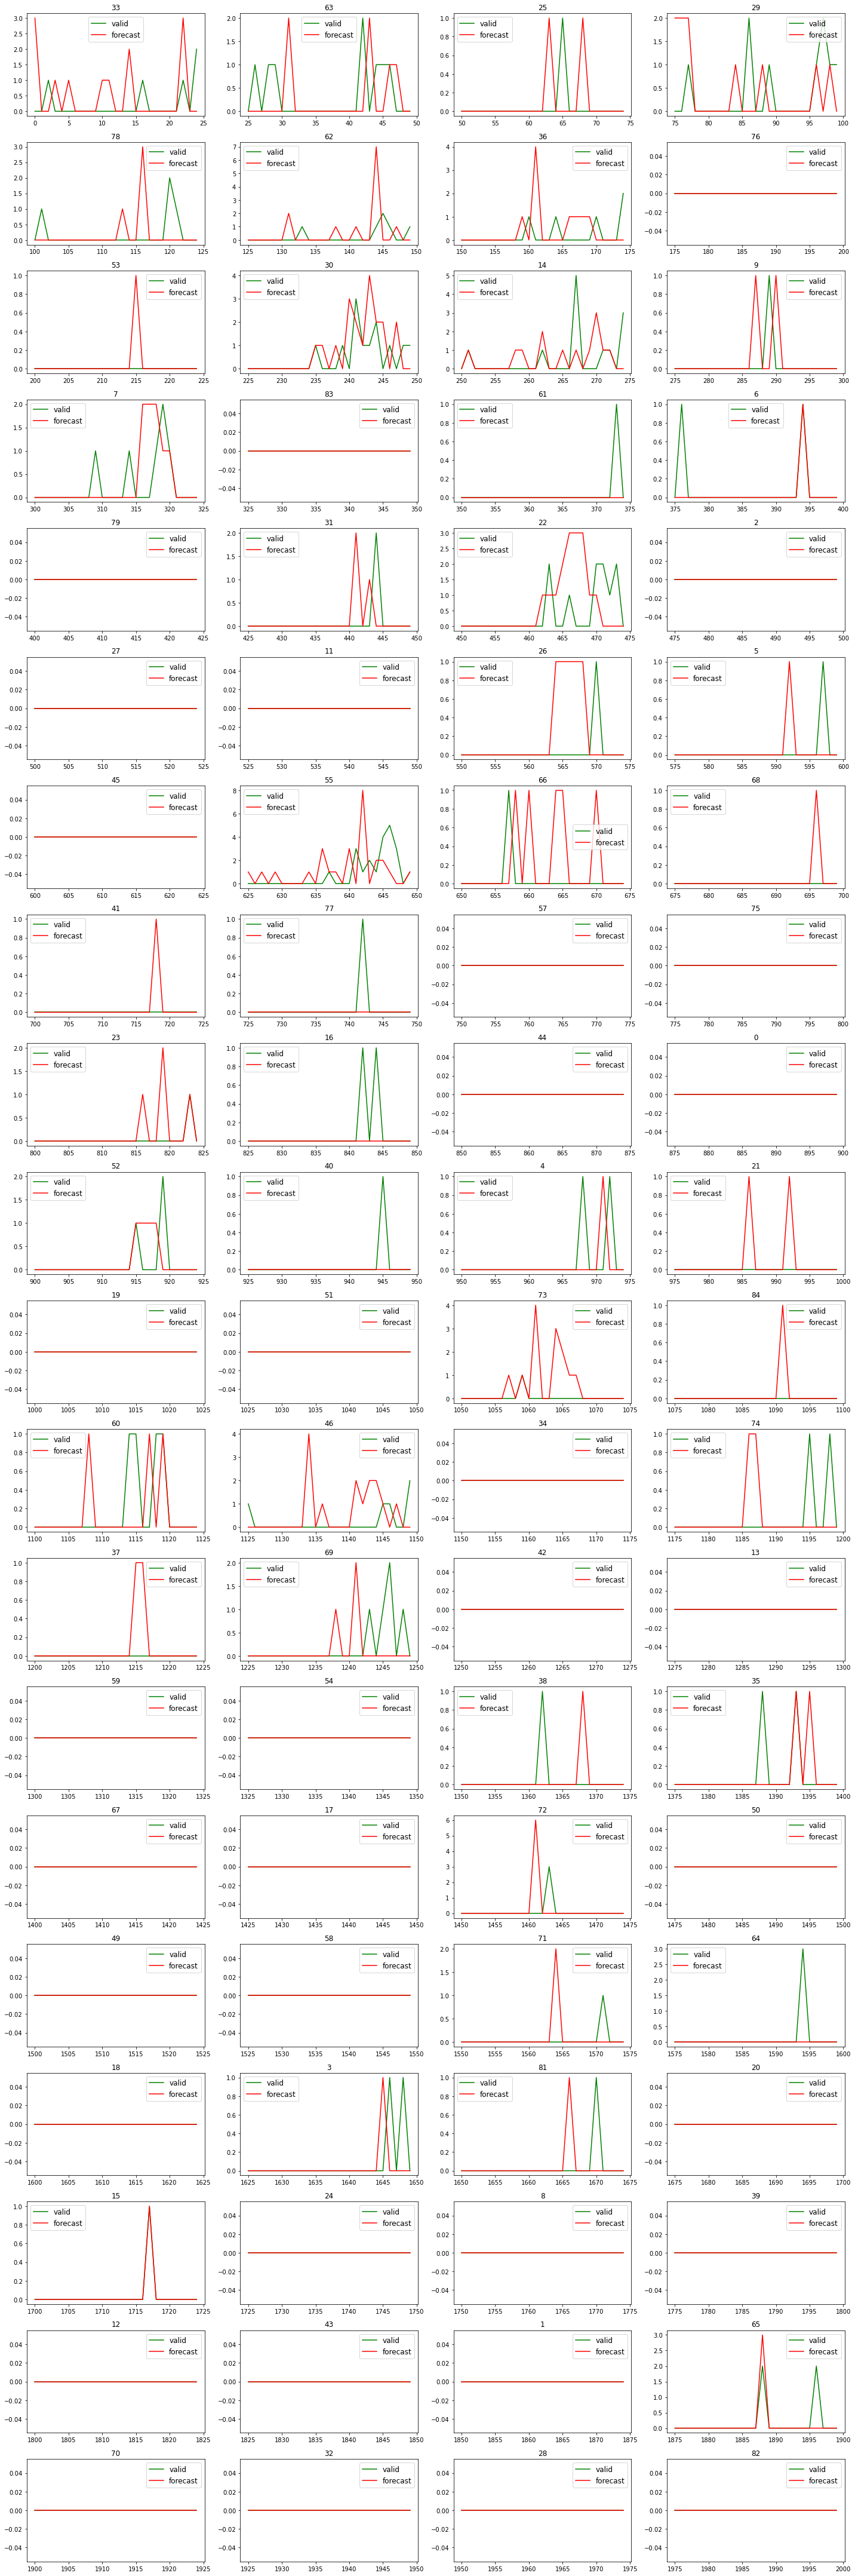

In [16]:
def print_scores(stage, X):
    print('Scores for ' + stage)
    print('R2 ', r2_score(X.quantity_sum, X.quantity_sum_naive))
    print('RMSE ', rmse(X.quantity_sum, X.quantity_sum_naive))
    print('MAE ', mae(X.quantity_sum, X.quantity_sum_naive))
    
def baseline_plot(stage, matrix, Y, day, plot):         
    masked_series = matrix.local_date.between(valid_day-pd.Timedelta(days=1, hours=1), valid_day-pd.Timedelta(hours=1), inclusive=True)
    prev_day = matrix.loc[masked_series,:].reset_index(drop=True)
    X = pd.concat([pd.Series(Y.reset_index(drop=True), index=prev_day.index, name='quantity_sum_naive'), prev_day], axis=1)    
    print_scores(stage, X)    
    
    if plot:
        fig, ax = plt.subplots(20, 4, figsize=(20, 60))
        ax = ax.flatten()
        for i, reg in enumerate(regions):
            ax[i].plot(X[X.region == reg]['quantity_sum'], color='g', label='valid')
            ax[i].plot(X[X.region == reg]['quantity_sum_naive'], color='r', label='forecast')
            ax[i].set_title(reg)
            ax[i].legend(prop={"size": 12})
        plt.tight_layout() 

PLOT = True
valid_day = pd.to_datetime(datetime(2021, 2, 6, 0, 0))
baseline_plot('Naive validation', matrix, Y_valid, valid_day, PLOT)

# date_before = pd.to_datetime(datetime(2021, 2, 6, 0, 0))
# baseline_plot('Naive test', matrix, Y_test, date_before, False)        

## Обучение на полном датасете

In [17]:
mode = 'test'
test_day = df.local_date.max() + pd.Timedelta(hours=1)
X_train,Y_train, X_test, Y_test, matrix = make_feature(df, regions, test_day, mode)

# Final train and val datasets
print('X Train shape:{}, X test shape:{}'.format(X_train.shape, X_test.shape))
print('Y Train shape:{}, Y test shape:{}'.format(Y_train.shape, Y_test.shape))

hyper_params = {'task':'train', 'n_estimators' : 30, 'boosting_type':'gbdt', 'objective':'regression_L2', 
              'metric': 'mae', 'num_leaves': 10, 'learning_rate': 0.01, 
              'feature_fraction': 1, 'max_depth': 5, 'verbose': 0, 
              'num_boost_round':1000, 'nthread':-1}


model, val_df = lgb_validation(hyper_params, X_train, Y_train, X_test, Y_test, 0, mode)
time.time() - ts

C:\Users\bognev\anaconda3\envs\tf-gpu-clone\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


X Train shape:(11600, 21), X test shape:(1920, 21)
Y Train shape:(11600,), Y test shape:(1920,)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

29.89121174812317

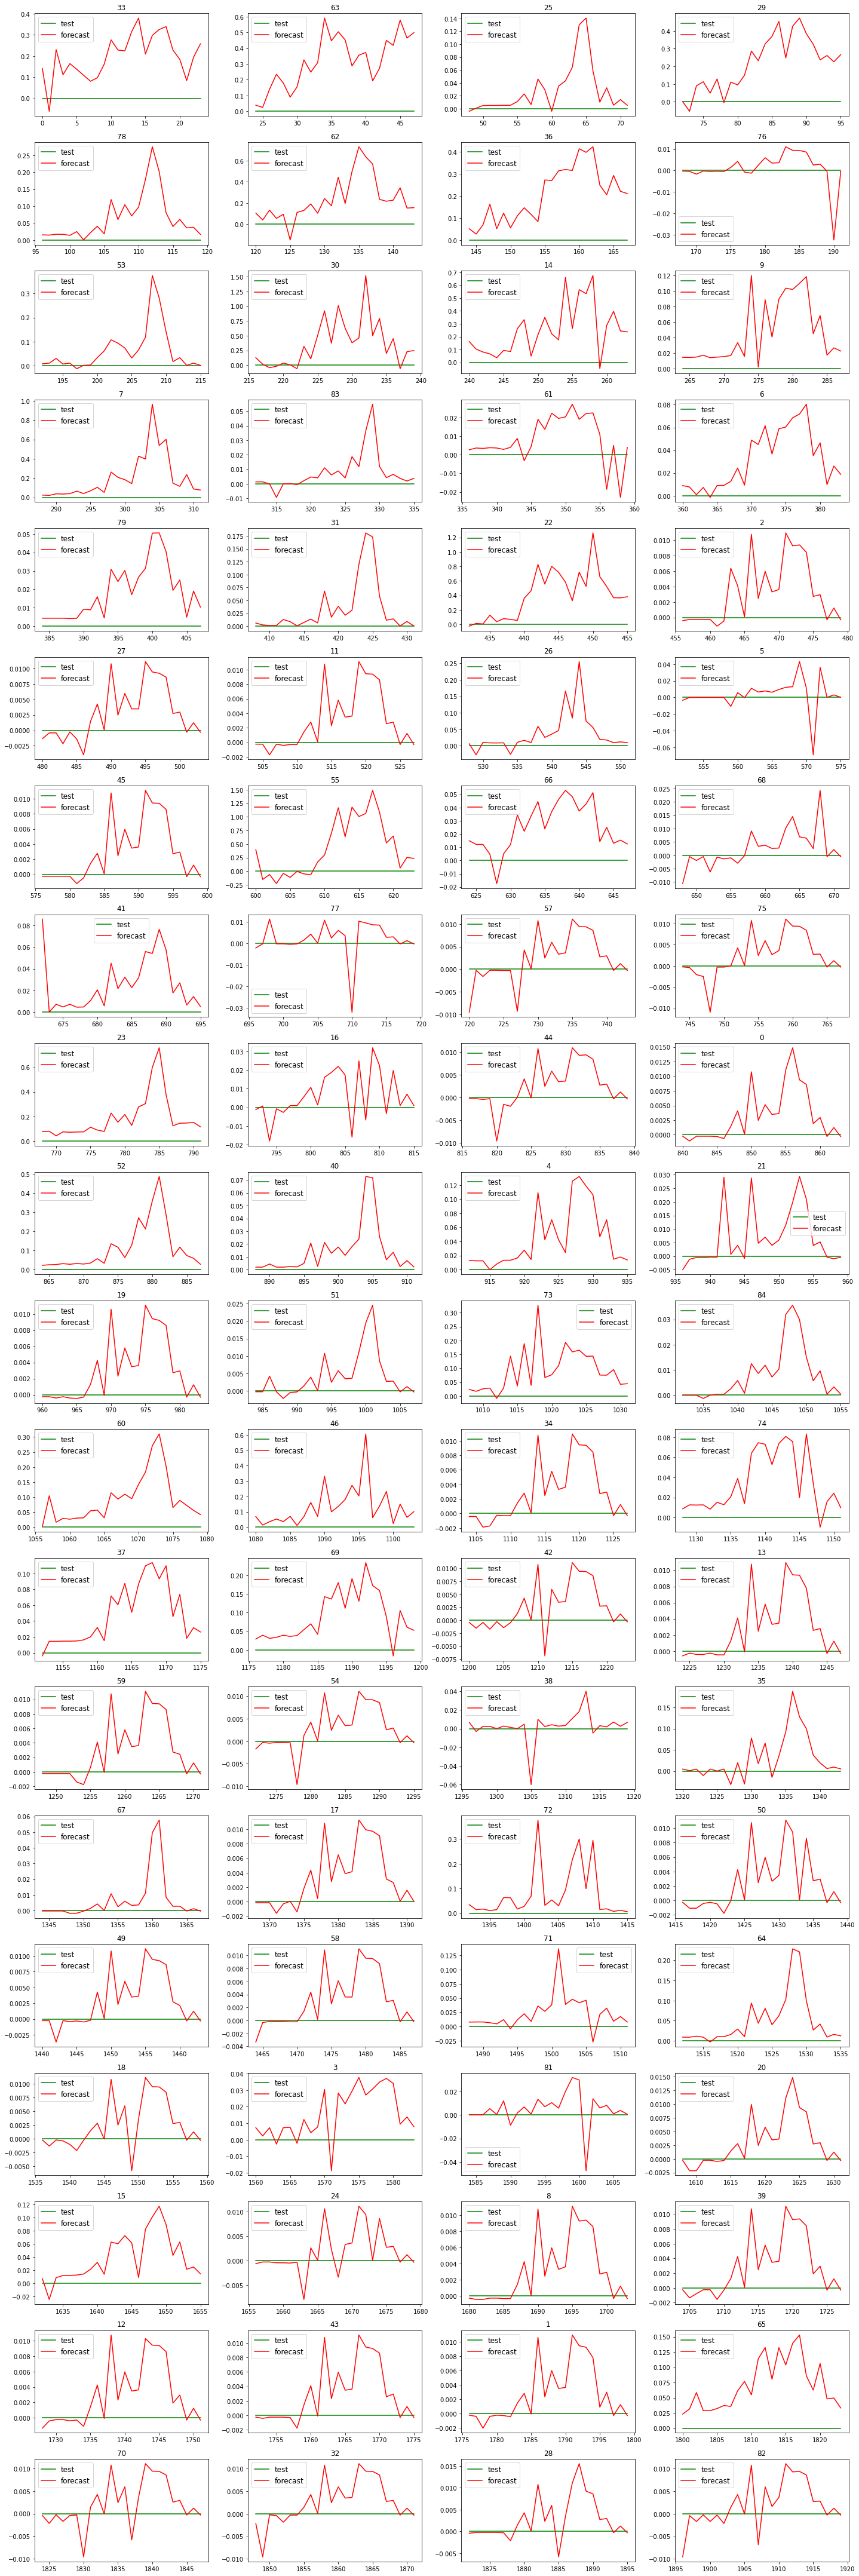

In [18]:
X = pd.concat([X_test, val_df], axis=1)

fig, ax = plt.subplots(20, 4, figsize=(20, 60))
ax = ax.flatten()
for i, reg in enumerate(regions):
    ax[i].plot(X[X.region == reg]['Y_valid'], color='g', label='test')
    ax[i].plot(X[X.region == reg]['Y_pred'], color='r', label='forecast')
    ax[i].set_title(reg)
    ax[i].legend(prop={"size": 12})
plt.tight_layout()    

In [19]:
report = pd.merge(X[['day', 'hour', 'region', 'Y_pred']], dataset[['region', 'region_str']].drop_duplicates(), on = 'region', how='inner')
def f(x):      
    return pd.to_datetime(datetime(2021, 2, x.day, x.hour, 0))

report['local_date'] = report.apply(f, axis=1)
report

,day,hour,region,Y_pred,region_str,local_date
0,7,2,33,0.140808,Нижегородская область,2021-02-07 02:00:00
1,7,3,33,-0.060832,Нижегородская область,2021-02-07 03:00:00
2,7,4,33,0.230234,Нижегородская область,2021-02-07 04:00:00
3,7,5,33,0.111586,Нижегородская область,2021-02-07 05:00:00
4,7,6,33,0.163932,Нижегородская область,2021-02-07 06:00:00
...,...,...,...,...,...,...
1915,7,21,82,0.002726,Чукотский автономный округ,2021-02-07 21:00:00
1916,7,22,82,0.002787,Чукотский автономный округ,2021-02-07 22:00:00
1917,7,23,82,-0.000303,Чукотский автономный округ,2021-02-07 23:00:00
1918,8,0,82,0.001226,Чукотский автономный округ,2021-02-08 00:00:00


In [20]:
report.to_csv('lightgbm_submission.csv', index=False)